Looking for a EEG stream...
Started acquiring data.
Looking for a Markers stream...
Can't find Markers stream.
Start recording at time t=1627878589.810
Time correction:  -1.5149940736591816e-05
Time correction:  -2.719997428357601e-05
Done - wrote file: ../Collected_Data/RawEEG/jaw_clench/jaw_clench_var1_10_raw.csv
Recording has ended


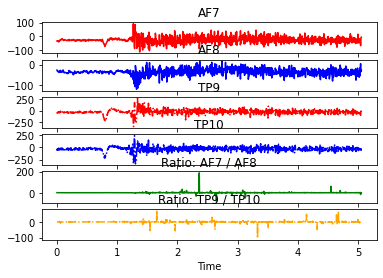

In [86]:
# Record and format Muse 2 data

from muselsl import record
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

action = "jaw_clench"
file = action + "_var1_10"
subfolder = ["RawEEG/", "FormattedEEG/"] 
folder = "../Collected_Data/"
input_file = folder + subfolder[0] + action + "/" + file + "_raw.csv"
output_file = folder+ subfolder[1] + action + "/" + file + "_formatted.csv"

# Note: an existing Muse LSL stream is required
record(6, input_file)
# Note: Recording is synchronous, so code here will not execute until the stream has been closed
print('Recording has ended')

# Read, format, and save recorded data
#plt.rcParams['figure.figsize'] = [10, 8]
#plt.rcParams['figure.dpi'] = 600 # 200 e.g. is really fine, but slower
df = pd.read_csv(input_file, usecols=[1,2,3,4,5,6], header=0, names=["TP9", "AF7", "AF8","TP10", "Time", "Offset"])
df["Time"] = df["Time"] + df["Offset"]
df["Time"] = df["Time"] - df["Time"].iloc[0]
del df["Offset"]

# Plot formatted data
fig,(graph0, graph1, graph2, graph3, graph4, graph5) = plt.subplots(nrows = 6, sharex = True)
line0, = graph0.plot(df["Time"], df["AF7"], color = "red", linestyle = "solid")
line1, = graph1.plot(df["Time"], df["AF8"], color = "blue", linestyle = "solid")
line2, =  graph2.plot(df["Time"], df["TP9"], color = "red", linestyle = "dashdot")
line3, = graph3.plot(df["Time"], df["TP10"], color = "blue", linestyle = "dashdot")
line4, = graph4.plot(df["Time"], (df["AF7"]/df["AF8"]), color = "green", linestyle = "solid")
line5, = graph5.plot(df["Time"], (df["TP9"]/df["TP10"]), color = "orange", linestyle = "dashdot")

graph0.title.set_text('AF7')
graph1.title.set_text('AF8')
graph2.title.set_text('TP9')
graph3.title.set_text('TP10')
graph4.title.set_text('Ratio: AF7 / AF8')
graph5.title.set_text('Ratio: TP9 / TP10')

#graph4.legend((line0, line1, line2, line3), ("AF7", "AF8", "TP9", "TP10"), loc='lower right')
plt.xlabel('Time')
plt.show()

# stores 5s time series in output_file 
del df["Time"]
df.to_csv(output_file)




In [ ]:
# plots data for testing/debug

file = "control_var3_3"
folder = "../Collected_Data/"
input_file = folder+"RawEEG/control/" + file + "_raw.csv"

df = pd.read_csv(input_file, usecols=[1,2,3,4,5,6], header=0, names=["TP9", "AF7", "AF8","TP10", "Time", "Offset"])
df["Time"] = df["Time"] + df["Offset"] - df["Time"].iloc[0]
del df["Offset"]

# Plot formatted data
fig,(graph0, graph1, graph2, graph3, graph4, graph5) = plt.subplots(nrows = 6, sharex = True)
line0, = graph0.plot(df["Time"], df["AF7"], color = "red", linestyle = "solid")
line1, = graph1.plot(df["Time"], df["AF8"], color = "blue", linestyle = "solid")
line2, =  graph2.plot(df["Time"], df["TP9"], color = "red", linestyle = "dashdot")
line3, = graph3.plot(df["Time"], df["TP10"], color = "blue", linestyle = "dashdot")
line4, = graph4.plot(df["Time"], (df["AF7"]/df["AF8"]), color = "green", linestyle = "solid")
line5, = graph5.plot(df["Time"], (df["TP9"]/df["TP10"]), color = "orange", linestyle = "dashdot")

graph0.title.set_text('AF7')
graph1.title.set_text('AF8')
graph2.title.set_text('TP9')
graph3.title.set_text('TP10')
graph4.title.set_text('Ratio: AF7 / AF8')
graph5.title.set_text('Ratio: TP9 / TP10')

#graph4.legend((line0, line1, line2, line3), ("AF7", "AF8", "TP9", "TP10"), loc='lower right')
plt.xlabel('Time')
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# control = 0, left = 1, right = 2

def read_all_csvs():
    folder = "../Collected_Data/FormattedEEG/"
    types = ["control", "left_blink", "right_blink", "jaw_clench"]
    csv_paths = np.array([["left_blink_var1", 1], ["left_blink_var2", 1], ["right_blink_var1", 2], ["right_blink_var2", 2], ["control_var1", 0], ["control_var2", 0], ["control_var3", 0], ["jaw_clench_var1", 3], ["jaw_clench_var2", 3]])
    
    output_x = []
    output_y = []
    
    for path in csv_paths:
        i = 1
        while True:
            try:
                cur_path = folder + types[int(path[1])] + "/" + path[0] + "_" + str(i) + "_" + "formatted.csv"
                print(cur_path)
                input_data = pd.read_csv(cur_path, header = 0, usecols=[1, 2, 3, 4])
                #print(input_data.head())
                X = input_data.to_numpy()[250:1000]
                X = X.T
                # print(X)
                y = path[1] 
                output_x.append(X)
                output_y.append(y)
                i += 1
            except:
                break;
    
    output_x = np.array(output_x) 
    output_y = np.array(output_y)
    print(output_x.shape, output_y.shape)
    return output_x, output_y

read_all_csvs()